In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering


# Demo - Embedding Initialisation

This demo is an extension on `1_default_usage.ipynb` and shows how you can initialise the model using pre-trained sentence embeddings. For this demo, we'll make use of Google's [universal-sentence-encoding-multilingual](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3) model.

The main idea behind initialising with pre-trained vectors is that the sentences similar to the labeled sentences (i.e. those in the training and validation cluster) are initially closer to each other in the embedding space. This gives a greater chance that they adapt with them during training, hence leading to an overall better result for those samples not labeled.

The goal of this demo is to cluster Flemish universities to a suitable cluster, while discarding all other schools/universities.

In [2]:
import re
import json
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from collections import Counter
from matplotlib.ticker import MaxNLocator

from semi_supervised_clustering import EmbeddingModel

## Data

Load in the dummy-data used throughout this demonstration.

In [3]:
# Consider only the profiles scraped from LinkedIn
DATA_PATH = Path.cwd() / 'demos/demo_data.json'

# Name assigned to the clustering-model
name = 'demo_emb_init'

In [4]:
def clean_f(x:str) -> str:
    """Cleaning function of the raw text."""
    x = x.lower()
    return re.sub('\W+', ' ', x).strip()

In [5]:
# Load in the data, and clean
with open(DATA_PATH, 'r') as f:
    data = json.load(f)

In [6]:
data_clean = [clean_f(s) for s in data]
data_unique = sorted(set(data_clean))
print(f"Total of {len(data_clean)} data samples")
data_count = [(k, v) for k, v in sorted(Counter(data_clean).items(), key=lambda x: x[1])]
print(f" --> {len(data_count)} unique")

print(f"\n10 most frequent samples:")
for sample, count in list(reversed(data_count))[:10]:
    print(f" - {sample} ({count})")

Total of 4689 data samples
 --> 706 unique

10 most frequent samples:
 - ku leuven (518)
 - katholieke universiteit leuven (411)
 - universiteit gent (340)
 - hogeschool gent (298)
 - vrije universiteit brussel (155)
 - vlerick business school (127)
 - université catholique de louvain (126)
 - groep t internationale hogeschool leuven (117)
 - ghent university (104)
 - universiteit antwerpen (101)


Analyse on frequency:
 - Sample frequency >=  0  --> 100% of all samples (706 samples in total)
 - Sample frequency >= 50  -->  61% of all samples (18 samples in total)
 - Sample frequency >= 100 -->  49% of all samples (10 samples in total)
 - Sample frequency >= 150 -->  37% of all samples (5 samples in total)
 - Sample frequency >= 200 -->  33% of all samples (4 samples in total)
 - Sample frequency >= 250 -->  33% of all samples (4 samples in total)
 - Sample frequency >= 300 -->  27% of all samples (3 samples in total)
 - Sample frequency >= 350 -->  20% of all samples (2 samples in total)
 - Sample frequency >= 400 -->  20% of all samples (2 samples in total)
 - Sample frequency >= 450 -->  11% of all samples (1 samples in total)
 - Sample frequency >= 500 -->  11% of all samples (1 samples in total)


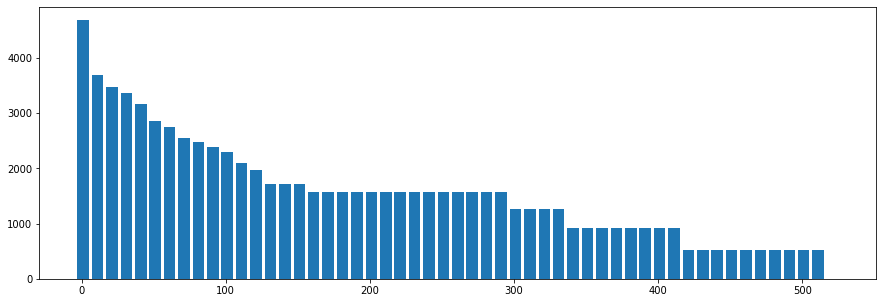

In [7]:
# Plot frequency of the data
counts = sorted([x for k,x in data_count], reverse=True)
x, y = [], []
for i in range(1, max(counts)+10, 10):
    x.append(i)
    y.append(sum(c for c in counts if i <= c))

print(f"Analyse on frequency:")
for freq in range(0,max(counts),50):
    print(f" - Sample frequency >= {freq:^3d} --> {round(100*sum(c for c in counts if freq <= c)/sum(counts)):3d}% of all samples ({len([c for c in counts if freq <= c])} samples in total)")

plt.figure(figsize=(15,5))
plt.bar(x, y, width=8)
plt.show()

## Model

Initialise the `EmbeddingModel`. This model consists of three main sub-models:
 - `encoder` to encode the raw sentences into machine-interpretable embeddings (multi-hot)
 - `embedder` to embed the multi-hot encoded vectors into dense embeddings
 - `clusterer` to cluster the dense embeddings and predict the best-suiting cluster

### Initialise

Initialise the model, by created each of its fundamental components. During this initialisation-step, you have the option to initialise the clusters yourselve (as done in this demo) or by answering a short survay of proposed clusters, done via CLI. The latter can be activated by setting `n_min_clusters` inside of `model.initialise_models` to a number larger than zero.

In [8]:
model = EmbeddingModel(
    name=name,
    path_model=Path.cwd() / f'demos/models/{name}',
    path_data=Path.cwd() / f'demos/data/{name}',
    clean_f=clean_f,
    vocab_size=200,
    model_layers=(50,50,),
    normalise=True,
    cluster_thr=.8,
)

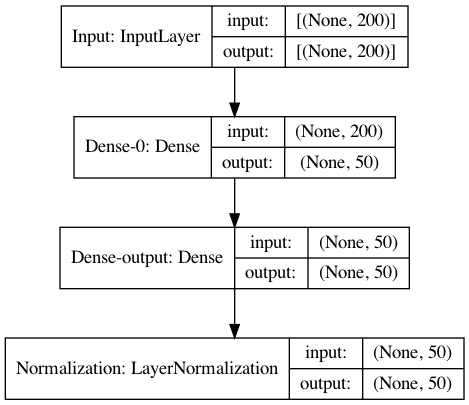

In [9]:
# Plot the model's architecture
tf.keras.utils.plot_model(
        model.embedder._model, 
        Path.cwd() / f"demos/models/{name}/{model.embedder}.png",
        show_shapes=True,
)

In [10]:
# Create some initial clusters
model.initialise_models(
    data=data,
    reset_encoder=True,
    reset_embedder=True,
    reset_clusterer=True,
    n_min_clusters=0,
    show_overview=True,
)



Analysing encoder 'encoder-demo_emb_init-bpe-200'

Analysing word 'ku leuven':
 --> Encoding: [38, 21]
 --> Word by word:
     - 38: ku
     - 21: leuven

Analysing word 'katholieke universiteit leuven':
 --> Encoding: [53, 29, 21]
 --> Word by word:
     - 53: katholieke
     - 29: universiteit
     - 21: leuven

Analysing word 'universiteit gent':
 --> Encoding: [29, 26]
 --> Word by word:
     - 29: universiteit
     - 26: gent

Analysing word 'hogeschool gent':
 --> Encoding: [32, 26]
 --> Word by word:
     - 32: hogeschool
     - 26: gent

Analysing word 'vrije universiteit brussel':
 --> Encoding: [102, 29, 57]
 --> Word by word:
     - 102: vrije
     - 29: universiteit
     - 57: brussel

Encoding the alphabet:
 - a = [36] = a
 - b = [42] = b
 - c = [64] = c
 - d = [177, 196] = d
 - e = [177, 176] = e
 - f = [174] = f
 - g = [12] = g
 - h = [78] = h
 - i = [141] = i
 - j = [177, 199] = j
 - k = [10] = k
 - l = [7] = l
 - m = [98] = m
 - n = [177, 178] = n
 - o = [81] = o
 - 

In [11]:
# Add training data manually
model.clusterer.add_clusters({
    'Catholic University of Leuven': ['kul', 'KU Leuven', 'katholieke universiteit leuven', 'Groep T', "Nayer Instituut", "universite de louvain"],
    'Free University of Brussels': ['VUB', 'Brussel Universiteit', 'vrije universiteit brussel'],
    'University of Ghent': ['Universiteit Gent', 'universite du gand', 'ugent'],
    'University of Hasselt': ['Hasselt Universiteit', 'uhasselt'],
    'University of Antwerp': ['UAntwerpen', 'universiteit antwerpen'],
    'Solvay Business School': ['Solvay', 'Solvay Brussel'],
    'Vlerick Business School': ['Vlerick', 'Vlerick Leuven', 'Vlerick Brussel'],
    None: ['hogeschool gent','hogeschool antwerpen','bme gent', 'syntra hasselt', 'hogeschool', 'syntra', 'kaho leuven']
})
print(f"Only {round(100*len(model.clusterer.get_training_data())/len(data_unique), 2)}% of all (cleaned) data classified")

No centroids created yet to store!
Only 4.96% of all (cleaned) data classified


In [12]:
# Add validation data manually
model.clusterer.add_validation({
    'Catholic University of Leuven': ['Louvain-la-Neuve', 'Groep T leuven', 'k u leuven'],
    'Free University of Brussels': ['vub Brussel', 'VU Brussel', 'brussel'],
    'University of Ghent': ['Université de Gand', 'rijksuniversiteit gent', 'ru gent'],
    'University of Hasselt': ['Hasselt', 'hasselt university', 'u hasselt'],
    'University of Antwerp': ['Universiteit van Antwerpen', 'u antwerpen', 'antwerpen'],
    'Solvay Business School': ['Solvay brussels school', 'solvay business school vub'],
    'Vlerick Business School': ['Vlerick business en management', 'vlerick leuven gent management school'],
    None: ['kaho sint lieven gent','hogent','karel de grote hogeschool katholieke hogeschool antwerpen','hogere zeevaartschool antwerpen','kaho gent']
})
print(f"{round(100*len(model.clusterer.get_validation_data())/len(data_unique), 2)}% of all (cleaned) data used for validation")

No centroids created yet to store!
3.4% of all (cleaned) data used for validation


In [13]:
# Validate the non-trained model's performance
model.clusterer.set_centroids(
    embedding_f=model.embed,
)
_ = model.validate(
    print_result=True,
)


Validation result:
 - Global  Accuracy: 54.17% (13/24)
 - Accuracy cluster: 42.11% (8/19)
 - Accuracy None   : 100.0% (5/5)
 - Number of predicted cluster: 33.33% (8/24)
 - Number of predicted None   : 66.67% (16/24)


## Pre-trained Embeddings

Load in the model used to compute the pre-trained embeddings, and define embeddings for all of the data-points. Note, since the pre-trained embeddings don't have the same dimension as out model's outputs, we'll create an intermediate mapping. A mapper (Single-Layer Perceptron) exists under `semi_supervised_clustering.mapping`, which we'll use to reduce the pre-trained embeddings' dimensions whilst retaining the inter-embedding cosine-similarity to our best effort. Note that it's ok that the pre-trained embeddings change, as long as the inter-embedding (and thus the inter-sample) relations remain.

In [14]:
%%capture
!pip install tensorflow_text

In [15]:
import numpy as np
import tensorflow_hub as hub
import tensorflow_text

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

from semi_supervised_clustering.mapper import Mapper

In [16]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'
model_use = hub.load(module_url)

def embed_text(text):
    return model_use(text)

In [17]:
embeddings_use = np.vstack([embed_text(d) for d in data_unique])
print(f"Embeddings-shape:", embeddings_use.shape)
similarity_use = cosine_similarity(embeddings_use)
print(f"Average similarity:", np.average(similarity_use))

Embeddings-shape: (706, 512)
Average similarity: 0.2557514


Loss 0.00102: 100%|██████████| 16/16 [00:22<00:00,  1.44s/it]


Model: "Mapper"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input-1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
Mapper (Dense)               (None, 50)                25650     
Total params: 25,650
Trainable params: 25,650
Non-trainable params: 0
_________________________________________________________________


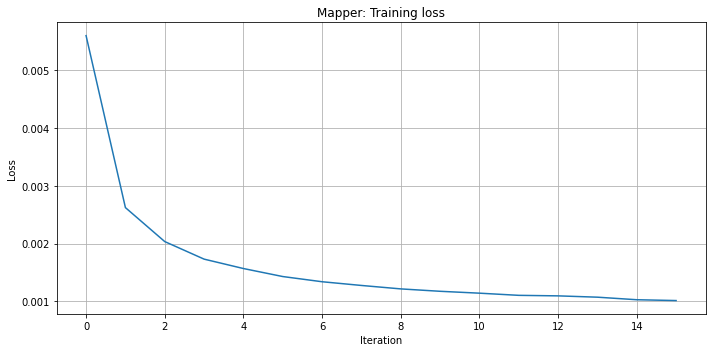

Shape original embeddings: (706, 512)
Shape mapped embeddings: (706, 50)
Average similarity: 0.25800133
Average cosine-similarity difference: 0.023790234395302833


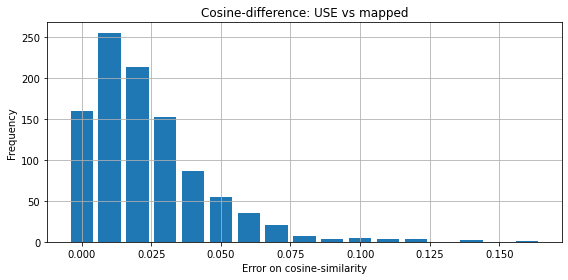

In [18]:
# Create a mapping to the requested dimension
mapper = Mapper(
    inp_size=512,
    out_size=50,
)
loss = mapper.train(
    embeddings=embeddings_use,
)
plt.figure(figsize=(10,5))
plt.plot(loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Mapper: Training loss")
plt.tight_layout()
plt.grid()
plt.show()

print(f"Shape original embeddings:", embeddings_use.shape)
embeddings_map = mapper(embeddings_use)
print(f"Shape mapped embeddings:", embeddings_map.shape)
similarity_map = cosine_similarity(embeddings_map)
print(f"Average similarity:", np.average(similarity_map))

# Validate the mapping by sampling and comparing cosine-similarities (original embs vs mapped)
indices = list(range(len(embeddings_use)))
idx1 = np.random.choice(indices, size=1000)
idx2 = np.random.choice(indices, size=1000)
similarities_diff = []
for i1, i2 in zip(idx1, idx2):
    similarities_diff.append(abs(similarity_use[i1,i2]-similarity_map[i1,i2]))
print(f"Average cosine-similarity difference:", sum(similarities_diff)/len(similarities_diff))
diff_counter = Counter([round(x, 2) for x in similarities_diff])
plt.figure(figsize=(8,4))
plt.bar(diff_counter.keys(), diff_counter.values(), .8e-2)
plt.xlabel("Error on cosine-similarity")
plt.ylabel("Frequency")
plt.title("Cosine-difference: USE vs mapped")
plt.tight_layout()
plt.grid()
plt.show()

Loss 0.24783: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


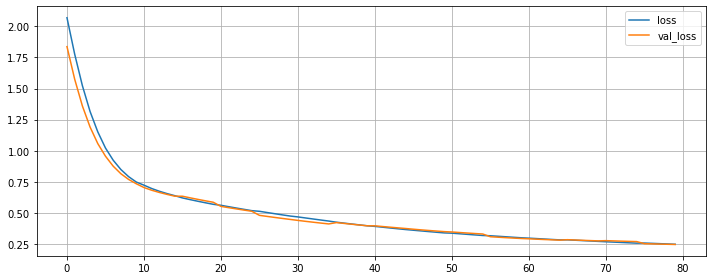

In [19]:
# Fit on the mapped embeddings
history = model.initialise_embeddings(
    data=data_unique,
    embeddings=embeddings_map,
    iterations=16,
) 

plt.figure(figsize=(10,4))
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Training

Model-training is done on the labeled (supervised) data and tries to reshape the embedding-space in a meaningful way. This *reshaping* happens via a *push-pull technique*:
 - **push** This training step pushes away the samples that do not belong in the same cluster. Say for example you have the samples `KU Leuven` and `UGent`, these do not belong in the same cluster, and thus should have a low cosine-similarity.
 - **pull** This training step pulls all the samples that belong in the same cluster together. Say for example you have the samples `KU Leuven` and `KUL`, these two samples belong to the same cluster, and thus should be close to each other.
 
Every `iteration`, one push and one pull are performed (in that order). Every `epoch`, there is the option to check new samples for which the model is uncertain about. This enables you to only annotate the most relevant samples.

In [20]:
tf.get_logger().setLevel('ERROR')
history = model.train(
    data=data_clean,
    epochs=1,
    iterations=32,
    batch_size=128,
    n_neg=16*128,
    n_pos=16*128,
    show_overview=True,
    debug=False,
)
tf.get_logger().setLevel('INFO')

Warmup, loss ???:   0%|          | 0/8 [00:00<?, ?it/s]

university of hasselt  -  Free University of Brussels
university of antwerp  -  University of Ghent
catholic university of leuven  -  Vlerick Business School
university of ghent  -  Free University of Brussels
hasselt universiteit  -  Vlerick Business School
catholic university of leuven  -  University of Ghent
nayer instituut  -  Free University of Brussels
ku leuven  -  Vlerick Business School
katholieke universiteit leuven  -  University of Ghent
university of ghent  -  Catholic University of Leuven
university of hasselt  -  University of Ghent
vlerick brussel  -  Catholic University of Leuven
universite de louvain  -  University of Ghent
hogeschool antwerpen  -  Catholic University of Leuven
vlerick  -  University of Antwerp
universiteit gent  -  University of Antwerp
free university of brussels  -  University of Hasselt
hogeschool gent  -  University of Hasselt
university of ghent  -  Solvay Business School
vlerick business school  -  Catholic University of Leuven
hogeschool antwe

Warmup, loss 0.11571:  12%|█▎        | 1/8 [00:00<00:02,  2.52it/s]

hogeschool gent  -  University of Hasselt
hogeschool gent  -  Free University of Brussels
syntra  -  University of Hasselt
kul  -  Vlerick Business School
solvay  -  University of Antwerp
hogeschool gent  -  Vlerick Business School
syntra  -  Free University of Brussels
university of hasselt  -  Catholic University of Leuven
university of hasselt  -  University of Antwerp
vub  -  Vlerick Business School
universiteit gent  -  University of Antwerp
bme gent  -  Solvay Business School
universiteit gent  -  University of Hasselt
hogeschool  -  Free University of Brussels
solvay brussel  -  University of Hasselt
kul  -  Free University of Brussels
kaho leuven  -  Free University of Brussels
vlerick leuven  -  Catholic University of Leuven
ugent  -  University of Hasselt
vub  -  Solvay Business School
ugent  -  Solvay Business School
groep t  -  Vlerick Business School
universiteit gent  -  Solvay Business School
hasselt universiteit  -  University of Antwerp
university of hasselt  -  Solvay

Warmup, loss 0.09534:  25%|██▌       | 2/8 [00:00<00:02,  2.35it/s]

solvay business school  -  Free University of Brussels
syntra hasselt  -  Vlerick Business School
syntra  -  University of Hasselt
katholieke universiteit leuven  -  Solvay Business School
bme gent  -  University of Hasselt
vrije universiteit brussel  -  University of Hasselt
hogeschool gent  -  University of Ghent
solvay business school  -  Vlerick Business School
universite de louvain  -  Solvay Business School
free university of brussels  -  University of Antwerp
ku leuven  -  University of Hasselt
universite de louvain  -  Free University of Brussels
uhasselt  -  Catholic University of Leuven
bme gent  -  Solvay Business School
brussel universiteit  -  University of Ghent
vlerick leuven  -  Free University of Brussels
hogeschool antwerpen  -  University of Ghent
kul  -  Free University of Brussels
solvay  -  Free University of Brussels
universiteit antwerpen  -  University of Hasselt
university of hasselt  -  Vlerick Business School
solvay  -  University of Hasselt
ku leuven  -  Vl

Warmup, loss 0.0786:  38%|███▊      | 3/8 [00:01<00:02,  2.35it/s] 

hogeschool antwerpen  -  Vlerick Business School
vlerick  -  Free University of Brussels
hogeschool  -  Catholic University of Leuven
groep t  -  University of Hasselt
kul  -  Vlerick Business School
free university of brussels  -  Catholic University of Leuven
vlerick  -  Catholic University of Leuven
vlerick leuven  -  Catholic University of Leuven
universiteit antwerpen  -  Free University of Brussels
hogeschool antwerpen  -  University of Antwerp
university of ghent  -  Vlerick Business School
universite du gand  -  University of Hasselt
brussel universiteit  -  Solvay Business School
bme gent  -  Catholic University of Leuven
kul  -  University of Hasselt
vub  -  University of Ghent
groep t  -  University of Hasselt
solvay brussel  -  University of Ghent
ugent  -  University of Antwerp
vrije universiteit brussel  -  University of Antwerp
katholieke universiteit leuven  -  University of Ghent
universite du gand  -  Catholic University of Leuven
solvay business school  -  Catholic U

Warmup, loss 0.06891:  50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

kaho leuven  -  Solvay Business School
hogeschool antwerpen  -  University of Antwerp
vlerick leuven  -  University of Hasselt
universiteit gent  -  Catholic University of Leuven
hogeschool gent  -  Free University of Brussels
ugent  -  University of Antwerp
catholic university of leuven  -  Free University of Brussels
hogeschool gent  -  Vlerick Business School
hogeschool antwerpen  -  University of Ghent
universiteit antwerpen  -  University of Hasselt
nayer instituut  -  Vlerick Business School
vub  -  Solvay Business School
universiteit gent  -  Catholic University of Leuven
vlerick brussel  -  Solvay Business School
uantwerpen  -  University of Hasselt
syntra  -  Catholic University of Leuven
vub  -  Solvay Business School
vlerick brussel  -  Free University of Brussels
hogeschool antwerpen  -  University of Ghent
vlerick leuven  -  University of Antwerp
kul  -  Solvay Business School
vlerick brussel  -  University of Antwerp
universiteit antwerpen  -  Catholic University of Leuve

Warmup, loss 0.06134:  62%|██████▎   | 5/8 [00:02<00:01,  2.23it/s]

syntra  -  Free University of Brussels
catholic university of leuven  -  University of Antwerp
vlerick business school  -  Free University of Brussels
hasselt universiteit  -  Free University of Brussels
ugent  -  Free University of Brussels
solvay business school  -  Free University of Brussels
hogeschool  -  Free University of Brussels
hasselt universiteit  -  University of Ghent
free university of brussels  -  University of Ghent
universite du gand  -  Solvay Business School
solvay  -  Free University of Brussels
ku leuven  -  University of Hasselt
uantwerpen  -  Catholic University of Leuven
bme gent  -  Free University of Brussels
groep t  -  Free University of Brussels
solvay brussel  -  University of Antwerp
universite du gand  -  Vlerick Business School
solvay brussel  -  Free University of Brussels
universiteit antwerpen  -  Catholic University of Leuven
solvay  -  University of Ghent
syntra  -  Solvay Business School
syntra  -  University of Antwerp
ku leuven  -  University o

Warmup, loss 0.05498:  75%|███████▌  | 6/8 [00:02<00:00,  2.26it/s]

universiteit gent  -  University of Hasselt
vlerick leuven  -  Solvay Business School
ugent  -  Solvay Business School
university of ghent  -  Solvay Business School
university of hasselt  -  University of Ghent
kul  -  University of Hasselt
hogeschool antwerpen  -  Catholic University of Leuven
vrije universiteit brussel  -  Solvay Business School
hasselt universiteit  -  Solvay Business School
universiteit antwerpen  -  Free University of Brussels
hogeschool gent  -  University of Antwerp
vrije universiteit brussel  -  Solvay Business School
universiteit antwerpen  -  Free University of Brussels
bme gent  -  Vlerick Business School
vub  -  University of Ghent
brussel universiteit  -  University of Antwerp
solvay  -  University of Antwerp
university of hasselt  -  University of Antwerp
universite du gand  -  University of Hasselt
hogeschool gent  -  University of Antwerp
brussel universiteit  -  Vlerick Business School
hasselt universiteit  -  University of Antwerp
hogeschool gent  - 

Warmup, loss 0.05368:  88%|████████▊ | 7/8 [00:03<00:00,  2.27it/s]

hogeschool  -  Vlerick Business School
ku leuven  -  Free University of Brussels
university of ghent  -  Catholic University of Leuven
vub  -  Vlerick Business School
vlerick brussel  -  Catholic University of Leuven
groep t  -  University of Antwerp
uantwerpen  -  University of Hasselt
uhasselt  -  University of Ghent
universite de louvain  -  Vlerick Business School
katholieke universiteit leuven  -  Free University of Brussels
vrije universiteit brussel  -  University of Hasselt
university of ghent  -  Vlerick Business School
kul  -  Solvay Business School
catholic university of leuven  -  University of Hasselt
university of antwerp  -  Free University of Brussels
kul  -  University of Ghent
vlerick  -  University of Ghent
vlerick leuven  -  University of Hasselt
universiteit gent  -  University of Hasselt
syntra hasselt  -  University of Hasselt
vlerick  -  University of Antwerp
universiteit antwerpen  -  Solvay Business School
vrije universiteit brussel  -  University of Antwerp
k

Loss ???:   0%|          | 0/32 [00:00<?, ?it/s]

==> Running epoch 1 <==
syntra hasselt  -  University of Hasselt
bme gent  -  Solvay Business School
kul  -  Solvay Business School
uantwerpen  -  Solvay Business School
vub  -  University of Antwerp
vlerick leuven  -  Free University of Brussels
vlerick  -  Free University of Brussels
solvay business school  -  University of Ghent
hogeschool  -  Solvay Business School
uhasselt  -  University of Ghent
nayer instituut  -  University of Hasselt
ugent  -  Catholic University of Leuven
free university of brussels  -  University of Ghent
katholieke universiteit leuven  -  Vlerick Business School
vub  -  Catholic University of Leuven
vub  -  Catholic University of Leuven
university of antwerp  -  Free University of Brussels
university of ghent  -  University of Antwerp
universiteit antwerpen  -  Vlerick Business School
ugent  -  Solvay Business School
hogeschool antwerpen  -  Solvay Business School
solvay brussel  -  University of Hasselt
vlerick brussel  -  Free University of Brussels
vleri

Loss 0.04705:   3%|▎         | 1/32 [00:00<00:12,  2.47it/s]

katholieke universiteit leuven  -  Free University of Brussels
hogeschool  -  University of Antwerp
vlerick leuven  -  Free University of Brussels
solvay business school  -  Catholic University of Leuven
kul  -  University of Hasselt
hogeschool  -  Solvay Business School
kul  -  Free University of Brussels
uantwerpen  -  University of Ghent
universiteit antwerpen  -  University of Hasselt
vlerick brussel  -  University of Hasselt
kul  -  Free University of Brussels
university of ghent  -  Solvay Business School
solvay brussel  -  University of Ghent
solvay business school  -  Catholic University of Leuven
hasselt universiteit  -  University of Antwerp
hogeschool  -  University of Ghent
university of antwerp  -  University of Hasselt
solvay business school  -  University of Hasselt
vub  -  Vlerick Business School
solvay  -  Free University of Brussels
syntra  -  Catholic University of Leuven
solvay brussel  -  Free University of Brussels
katholieke universiteit leuven  -  Vlerick Busine

Loss 0.04771:   6%|▋         | 2/32 [00:00<00:14,  2.14it/s]

solvay business school  -  University of Hasselt
uantwerpen  -  Solvay Business School
solvay  -  University of Hasselt
university of antwerp  -  University of Ghent
universiteit gent  -  Catholic University of Leuven
ugent  -  Free University of Brussels
hasselt universiteit  -  University of Ghent
university of antwerp  -  Free University of Brussels
hogeschool gent  -  Solvay Business School
hasselt universiteit  -  Solvay Business School
vlerick business school  -  University of Hasselt
vrije universiteit brussel  -  University of Hasselt
syntra hasselt  -  University of Hasselt
katholieke universiteit leuven  -  Vlerick Business School
nayer instituut  -  University of Ghent
hogeschool  -  Catholic University of Leuven
free university of brussels  -  University of Antwerp
universite de louvain  -  University of Ghent
vrije universiteit brussel  -  Solvay Business School
hogeschool  -  Solvay Business School
uhasselt  -  Solvay Business School
free university of brussels  -  Univer

Loss 0.0452:   9%|▉         | 3/32 [00:01<00:13,  2.22it/s] 

vrije universiteit brussel  -  Solvay Business School
bme gent  -  Catholic University of Leuven
university of antwerp  -  Free University of Brussels
hogeschool gent  -  Solvay Business School
solvay business school  -  Catholic University of Leuven
vub  -  University of Hasselt
catholic university of leuven  -  Solvay Business School
kul  -  University of Ghent
university of hasselt  -  University of Ghent
ugent  -  Free University of Brussels
vlerick  -  University of Hasselt
vlerick  -  Free University of Brussels
hasselt universiteit  -  University of Ghent
universite du gand  -  University of Antwerp
universite du gand  -  Vlerick Business School
solvay business school  -  University of Ghent
hogeschool  -  Vlerick Business School
vub  -  University of Hasselt
catholic university of leuven  -  Solvay Business School
vrije universiteit brussel  -  University of Ghent
universiteit antwerpen  -  Free University of Brussels
ku leuven  -  Vlerick Business School
free university of bru

Loss 0.04469:  12%|█▎        | 4/32 [00:01<00:12,  2.28it/s]

syntra  -  Vlerick Business School
solvay brussel  -  Free University of Brussels
kaho leuven  -  Vlerick Business School
syntra  -  University of Ghent
katholieke universiteit leuven  -  Vlerick Business School
vub  -  University of Antwerp
ugent  -  Solvay Business School
catholic university of leuven  -  University of Hasselt
hogeschool antwerpen  -  Solvay Business School
brussel universiteit  -  University of Hasselt
free university of brussels  -  University of Ghent
vub  -  Catholic University of Leuven
universiteit antwerpen  -  Free University of Brussels
solvay business school  -  University of Hasselt
universite du gand  -  Catholic University of Leuven
university of ghent  -  University of Antwerp
hogeschool antwerpen  -  University of Antwerp
university of ghent  -  Free University of Brussels
groep t  -  University of Antwerp
vlerick leuven  -  University of Ghent
university of hasselt  -  Catholic University of Leuven
universite de louvain  -  University of Ghent
hasselt

Loss 0.04484:  16%|█▌        | 5/32 [00:02<00:11,  2.29it/s]

groep t  -  University of Hasselt
hogeschool antwerpen  -  Vlerick Business School
catholic university of leuven  -  Vlerick Business School
syntra  -  University of Antwerp
catholic university of leuven  -  Free University of Brussels
solvay brussel  -  University of Antwerp
syntra hasselt  -  University of Hasselt
groep t  -  Free University of Brussels
vlerick  -  University of Ghent
vlerick brussel  -  Free University of Brussels
uantwerpen  -  University of Hasselt
vub  -  University of Hasselt
hogeschool gent  -  University of Hasselt
syntra  -  University of Antwerp
solvay brussel  -  Vlerick Business School
university of ghent  -  University of Antwerp
solvay brussel  -  Vlerick Business School
universite du gand  -  University of Hasselt
vlerick brussel  -  Catholic University of Leuven
vub  -  Catholic University of Leuven
uhasselt  -  Catholic University of Leuven
ku leuven  -  University of Hasselt
university of antwerp  -  Solvay Business School
solvay  -  Free University 

Loss 0.04196:  19%|█▉        | 6/32 [00:02<00:11,  2.19it/s]

groep t  -  University of Ghent
vlerick  -  Solvay Business School
katholieke universiteit leuven  -  University of Antwerp
universiteit gent  -  University of Antwerp
vlerick brussel  -  University of Hasselt
brussel universiteit  -  Catholic University of Leuven
kul  -  University of Antwerp
uhasselt  -  University of Antwerp
vub  -  Solvay Business School
bme gent  -  Free University of Brussels
university of hasselt  -  Vlerick Business School
university of antwerp  -  University of Hasselt
uantwerpen  -  University of Ghent
hogeschool gent  -  University of Ghent
vrije universiteit brussel  -  University of Ghent
university of antwerp  -  Solvay Business School
ugent  -  University of Hasselt
ugent  -  University of Hasselt
ku leuven  -  Vlerick Business School
nayer instituut  -  Free University of Brussels
uhasselt  -  University of Ghent
groep t  -  University of Hasselt
universite du gand  -  Free University of Brussels
hogeschool antwerpen  -  University of Ghent
syntra  -  U

Loss 0.04287:  22%|██▏       | 7/32 [00:03<00:10,  2.29it/s]

universite du gand  -  Solvay Business School
bme gent  -  University of Ghent
uhasselt  -  Solvay Business School
universiteit gent  -  University of Antwerp
university of hasselt  -  Vlerick Business School
groep t  -  Solvay Business School
universiteit antwerpen  -  Catholic University of Leuven
free university of brussels  -  Solvay Business School
vrije universiteit brussel  -  University of Ghent
solvay business school  -  University of Antwerp
solvay brussel  -  Catholic University of Leuven
university of hasselt  -  University of Antwerp
university of hasselt  -  University of Antwerp
vlerick brussel  -  University of Ghent
hasselt universiteit  -  Vlerick Business School
universiteit gent  -  Solvay Business School
university of hasselt  -  Free University of Brussels
solvay  -  University of Antwerp
universite de louvain  -  University of Ghent
brussel universiteit  -  University of Antwerp
university of hasselt  -  Vlerick Business School
uantwerpen  -  Vlerick Business Sch

Loss 0.04142:  25%|██▌       | 8/32 [00:03<00:10,  2.25it/s]

groep t  -  University of Hasselt
catholic university of leuven  -  University of Hasselt
universiteit antwerpen  -  Vlerick Business School
universite de louvain  -  Vlerick Business School
bme gent  -  University of Ghent
ugent  -  Free University of Brussels
university of ghent  -  Vlerick Business School
university of ghent  -  Catholic University of Leuven
syntra hasselt  -  University of Antwerp
hogeschool  -  Solvay Business School
universite du gand  -  Catholic University of Leuven
universite du gand  -  University of Hasselt
bme gent  -  Vlerick Business School
vlerick  -  Free University of Brussels
universite du gand  -  Vlerick Business School
uantwerpen  -  Solvay Business School
university of hasselt  -  Free University of Brussels
kul  -  Free University of Brussels
kul  -  Vlerick Business School
hasselt universiteit  -  Free University of Brussels
university of antwerp  -  University of Ghent
universite de louvain  -  Solvay Business School
university of antwerp  -  S

Loss 0.04045:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

hogeschool  -  University of Ghent
vlerick brussel  -  Free University of Brussels
hogeschool  -  University of Antwerp
universiteit antwerpen  -  Solvay Business School
groep t  -  Solvay Business School
ugent  -  Catholic University of Leuven
groep t  -  Vlerick Business School
universiteit gent  -  Catholic University of Leuven
university of antwerp  -  Vlerick Business School
ku leuven  -  University of Hasselt
vlerick  -  Free University of Brussels
vlerick business school  -  Catholic University of Leuven
solvay business school  -  Vlerick Business School
free university of brussels  -  Catholic University of Leuven
uantwerpen  -  University of Ghent
hogeschool  -  Vlerick Business School
vlerick brussel  -  University of Hasselt
hogeschool antwerpen  -  Solvay Business School
vrije universiteit brussel  -  Vlerick Business School
syntra  -  Vlerick Business School
universiteit antwerpen  -  Solvay Business School
ugent  -  University of Antwerp
nayer instituut  -  Vlerick Busine

Loss 0.04158:  31%|███▏      | 10/32 [00:04<00:08,  2.55it/s]

groep t  -  Vlerick Business School
vlerick business school  -  University of Antwerp
bme gent  -  University of Hasselt
kul  -  Vlerick Business School
vlerick business school  -  University of Hasselt
hogeschool antwerpen  -  Vlerick Business School
free university of brussels  -  University of Antwerp
uantwerpen  -  University of Ghent
hasselt universiteit  -  University of Antwerp
hogeschool  -  Vlerick Business School
university of hasselt  -  Free University of Brussels
hogeschool  -  University of Antwerp
nayer instituut  -  University of Antwerp
solvay  -  Catholic University of Leuven
nayer instituut  -  University of Hasselt
hasselt universiteit  -  Catholic University of Leuven
groep t  -  Vlerick Business School
groep t  -  Solvay Business School
syntra hasselt  -  University of Antwerp
vlerick leuven  -  University of Hasselt
hogeschool  -  Vlerick Business School
solvay business school  -  Vlerick Business School
nayer instituut  -  University of Ghent
bme gent  -  Univer

Loss 0.03992:  34%|███▍      | 11/32 [00:04<00:08,  2.49it/s]

nayer instituut  -  University of Ghent
kaho leuven  -  University of Hasselt
free university of brussels  -  Solvay Business School
nayer instituut  -  Free University of Brussels
university of antwerp  -  University of Ghent
vub  -  Solvay Business School
katholieke universiteit leuven  -  University of Hasselt
vlerick business school  -  Free University of Brussels
syntra hasselt  -  University of Antwerp
uhasselt  -  Free University of Brussels
solvay brussel  -  University of Antwerp
universite de louvain  -  University of Hasselt
solvay  -  Free University of Brussels
kaho leuven  -  Free University of Brussels
nayer instituut  -  University of Antwerp
catholic university of leuven  -  Free University of Brussels
kul  -  University of Hasselt
hasselt universiteit  -  University of Ghent
groep t  -  Free University of Brussels
vlerick  -  University of Ghent
hogeschool antwerpen  -  University of Ghent
uhasselt  -  Solvay Business School
solvay  -  Catholic University of Leuven
vl

Loss 0.03919:  38%|███▊      | 12/32 [00:05<00:08,  2.43it/s]

nayer instituut  -  University of Hasselt
universite du gand  -  University of Antwerp
university of antwerp  -  Solvay Business School
uhasselt  -  Solvay Business School
university of hasselt  -  Catholic University of Leuven
vlerick brussel  -  Free University of Brussels
kul  -  University of Ghent
uantwerpen  -  University of Hasselt
vlerick leuven  -  University of Hasselt
syntra hasselt  -  University of Ghent
vlerick  -  Catholic University of Leuven
syntra  -  Vlerick Business School
solvay  -  Free University of Brussels
katholieke universiteit leuven  -  Free University of Brussels
vrije universiteit brussel  -  Vlerick Business School
syntra hasselt  -  University of Ghent
solvay  -  University of Hasselt
university of hasselt  -  University of Ghent
vlerick  -  University of Antwerp
vrije universiteit brussel  -  University of Hasselt
universiteit antwerpen  -  Catholic University of Leuven
universiteit gent  -  Vlerick Business School
solvay  -  University of Antwerp
vler

Loss 0.03586:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

vrije universiteit brussel  -  Solvay Business School
bme gent  -  University of Hasselt
ku leuven  -  Vlerick Business School
vlerick leuven  -  University of Hasselt
universiteit antwerpen  -  Vlerick Business School
groep t  -  University of Hasselt
vlerick business school  -  Catholic University of Leuven
kul  -  University of Antwerp
solvay brussel  -  University of Ghent
nayer instituut  -  Solvay Business School
nayer instituut  -  Vlerick Business School
solvay brussel  -  University of Hasselt
vlerick business school  -  Free University of Brussels
solvay brussel  -  University of Antwerp
bme gent  -  Vlerick Business School
vrije universiteit brussel  -  Catholic University of Leuven
hogeschool  -  University of Hasselt
hogeschool  -  University of Ghent
vlerick  -  Free University of Brussels
vlerick brussel  -  University of Antwerp
hogeschool gent  -  Solvay Business School
solvay business school  -  University of Antwerp
universite de louvain  -  University of Ghent
solva

Loss 0.03759:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

uhasselt  -  Vlerick Business School
uantwerpen  -  Catholic University of Leuven
katholieke universiteit leuven  -  University of Antwerp
universiteit antwerpen  -  Vlerick Business School
vlerick leuven  -  University of Ghent
vub  -  University of Antwerp
vlerick brussel  -  University of Hasselt
hogeschool antwerpen  -  Free University of Brussels
hasselt universiteit  -  University of Ghent
groep t  -  University of Hasselt
vrije universiteit brussel  -  Catholic University of Leuven
universite de louvain  -  Vlerick Business School
ku leuven  -  University of Hasselt
hogeschool antwerpen  -  University of Antwerp
vlerick brussel  -  Catholic University of Leuven
university of ghent  -  University of Antwerp
nayer instituut  -  University of Hasselt
university of ghent  -  Vlerick Business School
kul  -  University of Ghent
hasselt universiteit  -  University of Antwerp
uantwerpen  -  Solvay Business School
bme gent  -  University of Hasselt
kul  -  University of Antwerp
groep t  

Loss 0.03655:  47%|████▋     | 15/32 [00:06<00:07,  2.19it/s]

vlerick business school  -  Catholic University of Leuven
university of ghent  -  Free University of Brussels
hogeschool gent  -  University of Ghent
vlerick leuven  -  Free University of Brussels
university of ghent  -  Catholic University of Leuven
brussel universiteit  -  Catholic University of Leuven
hogeschool gent  -  University of Ghent
kul  -  University of Ghent
hogeschool gent  -  Catholic University of Leuven
catholic university of leuven  -  Free University of Brussels
vlerick brussel  -  University of Antwerp
universite du gand  -  Vlerick Business School
katholieke universiteit leuven  -  Free University of Brussels
vlerick brussel  -  Free University of Brussels
uantwerpen  -  University of Ghent
hogeschool  -  University of Hasselt
solvay business school  -  Free University of Brussels
hasselt universiteit  -  University of Antwerp
hogeschool  -  University of Ghent
university of antwerp  -  Free University of Brussels
free university of brussels  -  Vlerick Business Sc

Loss 0.03535:  50%|█████     | 16/32 [00:06<00:07,  2.25it/s]

kul  -  University of Hasselt
vlerick brussel  -  University of Antwerp
nayer instituut  -  University of Hasselt
vlerick  -  University of Ghent
solvay brussel  -  University of Antwerp
solvay  -  University of Hasselt
universite de louvain  -  University of Antwerp
universite du gand  -  University of Antwerp
university of antwerp  -  University of Ghent
syntra  -  University of Ghent
groep t  -  Solvay Business School
brussel universiteit  -  Catholic University of Leuven
brussel universiteit  -  Catholic University of Leuven
brussel universiteit  -  University of Hasselt
nayer instituut  -  University of Antwerp
universite de louvain  -  Vlerick Business School
groep t  -  Free University of Brussels
universiteit antwerpen  -  Free University of Brussels
vlerick brussel  -  University of Antwerp
catholic university of leuven  -  University of Hasselt
solvay  -  University of Antwerp
catholic university of leuven  -  Solvay Business School
universite du gand  -  University of Antwer

Loss 0.03597:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

hogeschool antwerpen  -  Catholic University of Leuven
kaho leuven  -  Free University of Brussels
hogeschool gent  -  Vlerick Business School
ugent  -  Vlerick Business School
university of antwerp  -  Catholic University of Leuven
catholic university of leuven  -  Free University of Brussels
groep t  -  University of Hasselt
vrije universiteit brussel  -  University of Ghent
vlerick  -  University of Ghent
uantwerpen  -  Catholic University of Leuven
vrije universiteit brussel  -  Solvay Business School
solvay brussel  -  Free University of Brussels
universiteit antwerpen  -  University of Hasselt
university of hasselt  -  Vlerick Business School
solvay  -  University of Hasselt
hogeschool antwerpen  -  University of Antwerp
vlerick brussel  -  Catholic University of Leuven
hasselt universiteit  -  Catholic University of Leuven
ugent  -  Free University of Brussels
universite du gand  -  Vlerick Business School
hogeschool antwerpen  -  Catholic University of Leuven
hogeschool  -  Sol

Loss 0.03559:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

hogeschool  -  Free University of Brussels
syntra hasselt  -  Solvay Business School
hogeschool antwerpen  -  Solvay Business School
ugent  -  Solvay Business School
uantwerpen  -  Catholic University of Leuven
hasselt universiteit  -  Catholic University of Leuven
universite du gand  -  Vlerick Business School
nayer instituut  -  Free University of Brussels
free university of brussels  -  Solvay Business School
bme gent  -  Free University of Brussels
vlerick brussel  -  Solvay Business School
nayer instituut  -  University of Ghent
katholieke universiteit leuven  -  University of Hasselt
universiteit gent  -  University of Antwerp
solvay business school  -  University of Antwerp
uantwerpen  -  University of Hasselt
nayer instituut  -  University of Ghent
universite du gand  -  Catholic University of Leuven
uhasselt  -  Vlerick Business School
uantwerpen  -  Catholic University of Leuven
hogeschool gent  -  Free University of Brussels
kaho leuven  -  Free University of Brussels
syntra

Loss 0.0341:  59%|█████▉    | 19/32 [00:08<00:05,  2.42it/s] 

kaho leuven  -  Solvay Business School
solvay brussel  -  Free University of Brussels
free university of brussels  -  University of Hasselt
catholic university of leuven  -  University of Hasselt
vrije universiteit brussel  -  University of Antwerp
universite de louvain  -  University of Ghent
groep t  -  University of Antwerp
free university of brussels  -  University of Antwerp
hogeschool  -  Solvay Business School
vub  -  University of Ghent
syntra hasselt  -  Catholic University of Leuven
solvay  -  Free University of Brussels
university of antwerp  -  Solvay Business School
hogeschool gent  -  University of Ghent
ku leuven  -  University of Ghent
university of ghent  -  Free University of Brussels
vub  -  Catholic University of Leuven
vrije universiteit brussel  -  Vlerick Business School
syntra hasselt  -  University of Hasselt
vrije universiteit brussel  -  University of Hasselt
katholieke universiteit leuven  -  University of Antwerp
free university of brussels  -  Catholic Uni

Loss 0.03458:  62%|██████▎   | 20/32 [00:08<00:04,  2.57it/s]

vlerick leuven  -  Solvay Business School
kaho leuven  -  Solvay Business School
hasselt universiteit  -  Free University of Brussels
nayer instituut  -  University of Hasselt
syntra  -  University of Antwerp
nayer instituut  -  Free University of Brussels
hasselt universiteit  -  University of Antwerp
universite du gand  -  Catholic University of Leuven
uhasselt  -  Free University of Brussels
hasselt universiteit  -  University of Ghent
kaho leuven  -  Catholic University of Leuven
hogeschool  -  Catholic University of Leuven
university of antwerp  -  Vlerick Business School
solvay brussel  -  Free University of Brussels
free university of brussels  -  University of Antwerp
hogeschool  -  University of Antwerp
syntra  -  University of Antwerp
uantwerpen  -  Catholic University of Leuven
universite de louvain  -  University of Ghent
groep t  -  Vlerick Business School
hasselt universiteit  -  University of Ghent
kul  -  Vlerick Business School
ugent  -  University of Hasselt
uhasselt 

Loss 0.0347:  66%|██████▌   | 21/32 [00:08<00:04,  2.65it/s] 

groep t  -  Vlerick Business School
hogeschool  -  University of Hasselt
uantwerpen  -  Solvay Business School
universiteit antwerpen  -  Solvay Business School
vub  -  Solvay Business School
university of antwerp  -  Solvay Business School
vub  -  University of Ghent
nayer instituut  -  Free University of Brussels
kul  -  University of Antwerp
university of antwerp  -  University of Hasselt
free university of brussels  -  Vlerick Business School
vlerick brussel  -  Free University of Brussels
syntra hasselt  -  Catholic University of Leuven
vlerick leuven  -  Solvay Business School
solvay brussel  -  Vlerick Business School
nayer instituut  -  University of Hasselt
free university of brussels  -  Catholic University of Leuven
vlerick brussel  -  Solvay Business School
universite du gand  -  Catholic University of Leuven
catholic university of leuven  -  University of Antwerp
syntra hasselt  -  University of Hasselt
kaho leuven  -  University of Hasselt
free university of brussels  -  

Loss 0.03379:  69%|██████▉   | 22/32 [00:09<00:04,  2.41it/s]

solvay  -  Free University of Brussels
university of ghent  -  University of Hasselt
universite du gand  -  Vlerick Business School
hasselt universiteit  -  University of Antwerp
university of antwerp  -  University of Hasselt
uhasselt  -  University of Ghent
hogeschool antwerpen  -  Vlerick Business School
bme gent  -  Catholic University of Leuven
vlerick business school  -  University of Antwerp
vlerick business school  -  University of Ghent
universiteit antwerpen  -  University of Hasselt
hogeschool gent  -  Solvay Business School
vlerick brussel  -  Free University of Brussels
catholic university of leuven  -  Free University of Brussels
uantwerpen  -  Catholic University of Leuven
universiteit gent  -  Vlerick Business School
groep t  -  University of Antwerp
hogeschool  -  Free University of Brussels
syntra hasselt  -  Vlerick Business School
university of antwerp  -  Catholic University of Leuven
university of antwerp  -  Free University of Brussels
hogeschool antwerpen  -  Un

Loss 0.03377:  72%|███████▏  | 23/32 [00:09<00:03,  2.42it/s]

universiteit antwerpen  -  Catholic University of Leuven
groep t  -  Solvay Business School
universite du gand  -  Solvay Business School
university of antwerp  -  Catholic University of Leuven
free university of brussels  -  University of Antwerp
kaho leuven  -  Solvay Business School
uantwerpen  -  Catholic University of Leuven
vlerick business school  -  University of Antwerp
ugent  -  Catholic University of Leuven
uantwerpen  -  Solvay Business School
vlerick business school  -  Solvay Business School
ku leuven  -  Vlerick Business School
universiteit antwerpen  -  University of Ghent
bme gent  -  University of Antwerp
syntra hasselt  -  Catholic University of Leuven
vlerick brussel  -  University of Ghent
vlerick  -  University of Ghent
vlerick leuven  -  University of Ghent
ku leuven  -  Solvay Business School
bme gent  -  University of Hasselt
hogeschool  -  University of Antwerp
universiteit antwerpen  -  Catholic University of Leuven
ugent  -  Free University of Brussels
kul  

Loss 0.03324:  75%|███████▌  | 24/32 [00:10<00:03,  2.46it/s]

universite du gand  -  Vlerick Business School
universite de louvain  -  Solvay Business School
university of antwerp  -  Solvay Business School
groep t  -  Vlerick Business School
hogeschool  -  Catholic University of Leuven
hogeschool  -  Vlerick Business School
kaho leuven  -  Catholic University of Leuven
uantwerpen  -  Vlerick Business School
hasselt universiteit  -  University of Antwerp
nayer instituut  -  University of Hasselt
ugent  -  University of Antwerp
vrije universiteit brussel  -  University of Antwerp
vlerick business school  -  Free University of Brussels
uantwerpen  -  Catholic University of Leuven
university of ghent  -  Solvay Business School
nayer instituut  -  University of Ghent
hasselt universiteit  -  Free University of Brussels
vlerick  -  Free University of Brussels
solvay  -  Free University of Brussels
hogeschool antwerpen  -  University of Antwerp
kaho leuven  -  University of Ghent
universite du gand  -  Vlerick Business School
universite de louvain  -  

Loss 0.0325:  78%|███████▊  | 25/32 [00:10<00:02,  2.52it/s] 

vrije universiteit brussel  -  University of Antwerp
katholieke universiteit leuven  -  University of Hasselt
bme gent  -  University of Ghent
syntra hasselt  -  Vlerick Business School
syntra hasselt  -  University of Ghent
syntra  -  Solvay Business School
hogeschool antwerpen  -  University of Ghent
universite de louvain  -  University of Antwerp
hogeschool  -  Vlerick Business School
ku leuven  -  Free University of Brussels
solvay business school  -  Free University of Brussels
uantwerpen  -  Solvay Business School
vub  -  University of Antwerp
universiteit gent  -  University of Hasselt
vlerick brussel  -  Free University of Brussels
uantwerpen  -  University of Hasselt
vlerick business school  -  Solvay Business School
katholieke universiteit leuven  -  University of Hasselt
vlerick brussel  -  University of Ghent
solvay brussel  -  University of Antwerp
hogeschool gent  -  University of Ghent
free university of brussels  -  Vlerick Business School
universiteit gent  -  Vlerick 

Loss 0.03377:  81%|████████▏ | 26/32 [00:10<00:02,  2.55it/s]

universite de louvain  -  University of Hasselt
university of antwerp  -  University of Hasselt
groep t  -  Solvay Business School
ugent  -  Solvay Business School
vlerick leuven  -  Catholic University of Leuven
vub  -  Vlerick Business School
groep t  -  University of Ghent
kul  -  Vlerick Business School
vrije universiteit brussel  -  University of Hasselt
hogeschool gent  -  University of Ghent
ku leuven  -  University of Ghent
hogeschool  -  University of Antwerp
university of hasselt  -  Vlerick Business School
university of hasselt  -  University of Antwerp
uhasselt  -  Vlerick Business School
ugent  -  Vlerick Business School
hogeschool antwerpen  -  University of Antwerp
solvay business school  -  Vlerick Business School
universite de louvain  -  Vlerick Business School
university of ghent  -  University of Antwerp
hogeschool  -  University of Hasselt
catholic university of leuven  -  Free University of Brussels
brussel universiteit  -  University of Hasselt
hogeschool  -  Uni

Loss 0.03242:  84%|████████▍ | 27/32 [00:11<00:02,  2.49it/s]

hogeschool  -  Solvay Business School
solvay business school  -  Catholic University of Leuven
syntra hasselt  -  University of Hasselt
kaho leuven  -  University of Hasselt
brussel universiteit  -  University of Antwerp
nayer instituut  -  University of Antwerp
syntra  -  University of Ghent
hasselt universiteit  -  Vlerick Business School
hogeschool gent  -  University of Antwerp
groep t  -  University of Ghent
universiteit gent  -  Catholic University of Leuven
ku leuven  -  University of Hasselt
uantwerpen  -  Catholic University of Leuven
kul  -  Vlerick Business School
hogeschool antwerpen  -  University of Antwerp
bme gent  -  Free University of Brussels
vrije universiteit brussel  -  University of Antwerp
nayer instituut  -  University of Antwerp
free university of brussels  -  University of Ghent
vlerick business school  -  Solvay Business School
hogeschool  -  Solvay Business School
ku leuven  -  University of Antwerp
syntra hasselt  -  Solvay Business School
uhasselt  -  Cat

Loss 0.0339:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s] 

university of hasselt  -  Catholic University of Leuven
university of ghent  -  University of Hasselt
free university of brussels  -  Vlerick Business School
groep t  -  Vlerick Business School
nayer instituut  -  Vlerick Business School
hogeschool antwerpen  -  Free University of Brussels
katholieke universiteit leuven  -  Solvay Business School
ku leuven  -  Free University of Brussels
bme gent  -  University of Ghent
vlerick brussel  -  University of Antwerp
vlerick business school  -  University of Ghent
free university of brussels  -  Solvay Business School
vlerick leuven  -  Free University of Brussels
groep t  -  Solvay Business School
vlerick brussel  -  Free University of Brussels
ugent  -  Solvay Business School
nayer instituut  -  Free University of Brussels
hasselt universiteit  -  Catholic University of Leuven
hogeschool gent  -  Vlerick Business School
solvay  -  University of Hasselt
katholieke universiteit leuven  -  University of Ghent
groep t  -  Free University of Br

Loss 0.03302:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

vrije universiteit brussel  -  Solvay Business School
vrije universiteit brussel  -  University of Antwerp
syntra  -  University of Ghent
bme gent  -  University of Hasselt
vlerick  -  University of Ghent
syntra  -  University of Ghent
bme gent  -  Solvay Business School
brussel universiteit  -  Solvay Business School
bme gent  -  University of Hasselt
bme gent  -  Solvay Business School
universite de louvain  -  Free University of Brussels
hogeschool gent  -  Catholic University of Leuven
hogeschool gent  -  Free University of Brussels
universiteit gent  -  University of Antwerp
vlerick  -  University of Ghent
free university of brussels  -  University of Hasselt
catholic university of leuven  -  University of Antwerp
universiteit antwerpen  -  University of Hasselt
university of ghent  -  Catholic University of Leuven
universiteit gent  -  Free University of Brussels
ugent  -  University of Antwerp
university of ghent  -  University of Antwerp
ugent  -  Solvay Business School
syntra 

Loss 0.03329:  94%|█████████▍| 30/32 [00:12<00:00,  2.29it/s]

university of antwerp  -  Vlerick Business School
katholieke universiteit leuven  -  Vlerick Business School
catholic university of leuven  -  Solvay Business School
ugent  -  Catholic University of Leuven
nayer instituut  -  University of Ghent
solvay business school  -  Free University of Brussels
hasselt universiteit  -  University of Ghent
hogeschool  -  University of Ghent
vrije universiteit brussel  -  University of Hasselt
vlerick business school  -  University of Hasselt
solvay  -  Vlerick Business School
solvay business school  -  Free University of Brussels
hogeschool antwerpen  -  Vlerick Business School
universite de louvain  -  University of Hasselt
solvay  -  Free University of Brussels
nayer instituut  -  University of Hasselt
vlerick leuven  -  Catholic University of Leuven
vlerick  -  University of Hasselt
brussel universiteit  -  Catholic University of Leuven
groep t  -  Free University of Brussels
hasselt universiteit  -  Vlerick Business School
uantwerpen  -  Univer

Loss 0.03453:  97%|█████████▋| 31/32 [00:13<00:00,  2.42it/s]

bme gent  -  University of Ghent
vrije universiteit brussel  -  University of Hasselt
vlerick business school  -  Catholic University of Leuven
solvay business school  -  Free University of Brussels
syntra hasselt  -  Solvay Business School
ku leuven  -  University of Ghent
hogeschool antwerpen  -  Vlerick Business School
university of antwerp  -  University of Hasselt
solvay brussel  -  University of Ghent
vub  -  University of Hasselt
ku leuven  -  Vlerick Business School
syntra  -  University of Hasselt
universite de louvain  -  University of Hasselt
universite de louvain  -  University of Hasselt
ku leuven  -  University of Ghent
hasselt universiteit  -  Vlerick Business School
hogeschool antwerpen  -  University of Ghent
free university of brussels  -  University of Antwerp
kaho leuven  -  Solvay Business School
nayer instituut  -  Free University of Brussels
syntra  -  Free University of Brussels
vlerick brussel  -  Solvay Business School
universiteit gent  -  Vlerick Business Sc

Loss 0.03239: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]



Training-clustering overview:
 - Unclustered: 58.9% (427/725)
 - Largest cluster: 121
 - Average cluster: 37.25
 - Smallest cluster: 9

Validation result:
 - Global  Accuracy: 100.0% (24/24)
 - Accuracy cluster: 100.0% (19/19)
 - Accuracy None   : 100.0% (5/5)
 - Number of predicted cluster: 79.17% (19/24)
 - Number of predicted None   : 20.83% (5/24)


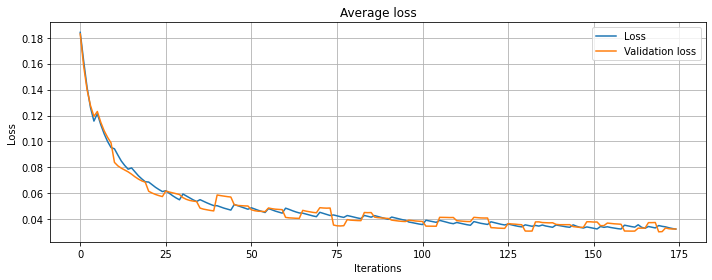

In [21]:
# Plot the loss-graphs
loss, val_loss = history['loss'], history['val_loss']
plt.figure(figsize=(10, 4))
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation loss')
plt.title("Average loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.tight_layout()
_ = plt.plot()

In [22]:
# Get overview of all validation predictions
val_result = model.validate(
    print_result=True,
)

print(f"\n\nClustering results:")
for a,b,c in val_result:
    print(f" - Clustering item '{a}'")
    print(f"   -->    Target-class: '{b}'")
    print(f"   --> Predicted-class: '{c}'")


Validation result:
 - Global  Accuracy: 100.0% (24/24)
 - Accuracy cluster: 100.0% (19/19)
 - Accuracy None   : 100.0% (5/5)
 - Number of predicted cluster: 79.17% (19/24)
 - Number of predicted None   : 20.83% (5/24)


Clustering results:
 - Clustering item 'hogent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'hogere zeevaartschool antwerpen'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'kaho gent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'kaho sint lieven gent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'karel de grote hogeschool katholieke hogeschool antwerpen'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'groep t leuven'
   -->    Target-class: 'Catholic University of Leuven'
   --> Predicted-class: 'Catholic University of Leuven'
 - Clustering item 'k u leuven'
   -->    Target-class: 'Catholic U

In [23]:
# Get closest cluster (together with cosine-similarity) for misclassified samples
misclassified = [a for a,b,c in val_result if b != c]
best_matches = model.get_cluster_prob(misclassified)

print(f"Closest cluster for misclassified samples:")
for item,(pred,certainty) in zip(misclassified, best_matches):
    print(f" - Clustering item '{item}'")
    print(f"   -->   Closest cluster: '{pred}'")
    print(f"   --> Cosine similarity: '{round(certainty,3):.3f}'")

Closest cluster for misclassified samples:


In [24]:
# Get ratio of data clustered
pred = model(data_unique)
pred_count = Counter(pred)
print(f"Prediction cluster-distribution:")
print(f" - Average of {round(100*len([p for p in pred if p])/len(pred), 2)}% clustered")
print(f" - Maximum cluster-size (not-None): {max(v for k,v in pred_count.items() if k)} samples")
print(f" - Average cluster-size (not-None): {round(sum(v for k,v in pred_count.items() if k)/(len(pred_count)-1))} samples")
print(f" - Minimum cluster-size (not-None): {min(v for k,v in pred_count.items() if k)} samples")
print(f" - Cluster by count:")
for k,v in sorted(pred_count.items(), key=lambda x: -x[1]):
    print(f"   - {k} ({v})")

Prediction cluster-distribution:
 - Average of 39.94% clustered
 - Maximum cluster-size (not-None): 118 samples
 - Average cluster-size (not-None): 40 samples
 - Minimum cluster-size (not-None): 8 samples
 - Cluster by count:
   - None (424)
   - Catholic University of Leuven (118)
   - University of Ghent (49)
   - University of Antwerp (34)
   - University of Hasselt (30)
   - Free University of Brussels (27)
   - Vlerick Business School (16)
   - Solvay Business School (8)


In [25]:
# Get ratio of data clustered (in absolute values, not uniques)
data_inp, counts = zip(*data_count)
pred = model(data_inp)
pred_count = Counter()
for p,c in zip(pred, counts):
    pred_count[p] += c

print(f"Prediction cluster-distribution, absolute figures:")
print(f" - Average of {round(100*(sum(counts)-pred_count[None])/sum(counts), 2)}% clustered")

max_c = sorted(pred_count.items(), key=lambda x: -x[1] if x[0] else 0).pop(0)
print(f" - Maximum cluster-size (not-None): cluster '{max_c[0]}' with {max_c[1]} samples")

med_c = sorted(pred_count.items(), key=lambda x: -x[1] if x[0] else 0).pop(len(pred_count)//2)
print(f" -  Median cluster-size (not-None): cluster '{med_c[0]}' with {med_c[1]} samples")

min_c = sorted(pred_count.items(), key=lambda x: -x[1] if x[0] else -max(pred_count.values())).pop(-1)
print(f" - Minimum cluster-size (not-None): cluster '{min_c[0]}' with {min_c[1]} samples")

print(f" - Cluster by count:")
for k,v in sorted(pred_count.items(), key=lambda x: -x[1]):
    print(f"   - {k} ({v})")
    
print(f" - Top 10 unclustered:")
unclustered = [(a,c) for a,b,c in sorted(zip(data_inp, pred, counts), key=lambda x: -x[2]) if not b]
for k,v in unclustered[:10]:
    print(f"   - {k} ({v})")

Prediction cluster-distribution, absolute figures:
 - Average of 64.45% clustered
 - Maximum cluster-size (not-None): cluster 'Catholic University of Leuven' with 1509 samples
 -  Median cluster-size (not-None): cluster 'Vlerick Business School' with 186 samples
 - Minimum cluster-size (not-None): cluster 'Solvay Business School' with 92 samples
 - Cluster by count:
   - None (1667)
   - Catholic University of Leuven (1509)
   - University of Ghent (656)
   - Free University of Brussels (267)
   - University of Antwerp (197)
   - Vlerick Business School (186)
   - University of Hasselt (115)
   - Solvay Business School (92)
 - Top 10 unclustered:
   - hogeschool gent (298)
   - groep t internationale hogeschool leuven (117)
   - hogeschool antwerpen (93)
   - kuleuven (85)
   - karel de grote hogeschool katholieke hogeschool antwerpen (66)
   - bme gent (47)
   - erasmushogeschool brussel (46)
   - kaho sint lieven gent (45)
   - katholieke hogeschool leuven (35)
   - hogent (33)


## Visualise result

Visualise the embedding-space and (predicted) clusters using TensorBoard's Projector.

In [26]:
model.visualise_tensorboard(
    data=data_unique,
    path_projector=Path.cwd() / 'demos/projector',
    incl_none=False,
)

Run tensorboard in terminal:
tensorboard --logdir /Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering/demos/projector/demo_emb_init

Or run tensorboard in notebook:
%load_ext tensorboard
%tensorboard --logdir /Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering/demos/projector/demo_emb_init


Another insightful visualisation is to show the softmax probabilities for each and every cluster. This can be done using the `seaborn` library.

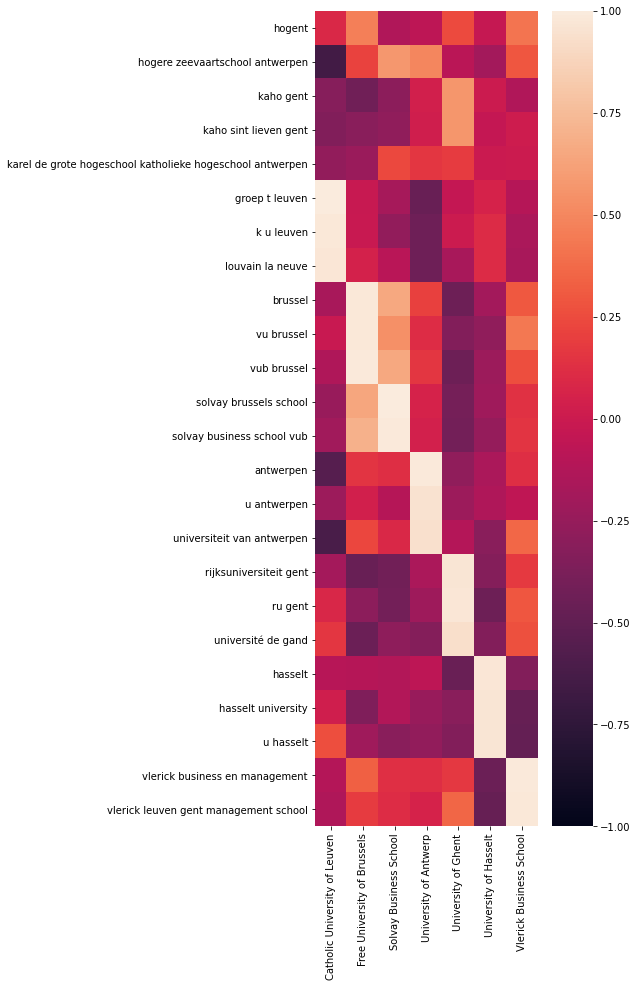

In [27]:
import seaborn as sns
validation_data = [k for k,_ in model.clusterer.get_validation_data()]
cluster_ids, probs = model.get_all_cluster_prob(validation_data)

plt.figure(figsize=(5,15))
sns.heatmap(probs, vmax=1, vmin=-1)
plt.xticks(ticks=[x+.5 for x in range(7)], labels=cluster_ids, rotation=90)
plt.yticks(ticks=[x+.5 for x in range(len(validation_data))], labels=validation_data, rotation=0)
_ = plt.show()

A last visualisation shows the similarities between the class centroids.

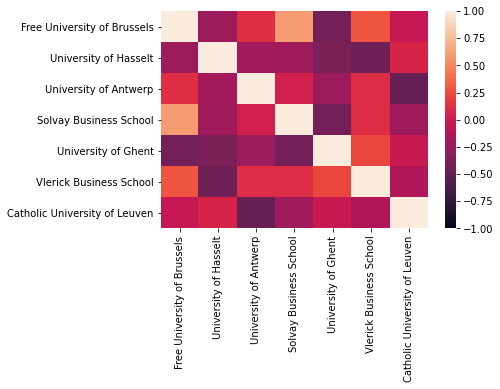

In [28]:
# Get current centroid-state
model.clusterer.set_centroids(embedding_f=model.embed)
centroids = model.clusterer.get_centroids()
labels, vectors = zip(*centroids.items())

# Calculate similarities and plot
sim = cosine_similarity(np.vstack(vectors))
sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmax=1, vmin=-1)
_ = plt.show()